# Tutorial #2 :: The Extended Kalman Filter - Position


In [1]:
import numpy as np
import scipy.linalg

def ekfUpdate(fcn_state,x,P,fcn_meas,z,Q,R):
    x1,A = linearize(fcn_state, x)
    P = A*P*A.T + Q
    z1,H = linearize(fcn_meas, x1)
    P12 = P*H.T
    R = scipy.linalg.cholesky( H*P12 + R )
    U = P12*np.linalg.pinv(R)
    dz = (z-z1)
    x = x1 +  U * np.linalg.pinv(R.T)*dz
    P = P - U*U.T
    return (x, P)

def linearize(fcn, x):
    z = fcn(x)
    n = len(x)
    m = len(z)
    A = np.mat( np.zeros( (m,n) ) )
    h = n*np.spacing(1)
    for k in range(n):
        x1 = np.matrix(x, dtype='complex')
        x1[k] += h*1j
        A[:,k] = fcn(x1).imag / h
    return (z, A)

# when we expand quaternion multiplication
def q_mult(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return np.array([w, x, y, z])

# and to conjugate a quaternion
def q_conj(q):
    w, x, y, z = q
    return np.array([w, -x, -y, -z])

# quaternion magnitude
def q_mag(q):
    w, x, y, z = q
    return np.sqrt( w*w + x*x + y*y + z*z )

This code will do all of the heavy lifting for us. Now we need to decide what we're trying to estimate (our state) along with how we will describe the dynamics of our system (`fcn_state`) and our observation function (`fcn_meas`).

Let's start with something practical--let's estimate the 2D position of the person walking around, whose inertial data we loaded and processed in Tutorial [1]. So what should our state vector $x$ contain? Well, it should for sure contain the position of the person, but we should also include the velocity, acceleration, *and* orientation of the person so that we can more easily predict future positions and measurements (observations) based on the current estimates. 

So we'll say $x = [\boldsymbol{p}, \boldsymbol{v}, \boldsymbol{a}, \boldsymbol{\theta}, \boldsymbol{\omega}]^T$, where $\boldsymbol{p}$ is 2D position, $\boldsymbol{v}$ is 2D linear velocity, $\boldsymbol{a}$ is 2D acceleration, and $\boldsymbol{\theta}$ is the 2D rotation of the object with respect to the global frame with corresponding angular velocity $\boldsymbol{\omega}$. 

Let's start with designing our state (process) equation, `fcn_state`. Note that, in addition to the state, we must pass `delta_t` to the state function. This allows us to evolve the state dynamics with knowledge of the elapsed time:

In [51]:
def fcn_state(state, delta_t, gyr_body, acc_body):
    px = state.item(0)
    py = state.item(1)
    pz = state.item(2)
    vx = state.item(3)
    vy = state.item(4)
    vz = state.item(5)
    qw  = state.item(6)
    qx  = state.item(7)
    qy  = state.item(8)
    qz  = state.item(9)
    p,q,r = gyr_body
    ax,ay,ax = acc_body
    
    # predicted next quaternion based on rotation
    qNow = np.array([[qw],[qx],[qy],[qz]])
    qGyr = np.array([[0],[p],[q],[r]])
    qChng = (1.0/2.0)*q_mult( qNow, qGyr )
    qNext = qNow + delta_t*qChng
    
    # normalize new quaternion
    qNext = qNext / q_mag(qNext)
    
    # world-frame accel. from body-frame.
    qAcc = np.array([[0],[ax],[ay],[az]])
    acc_world = q_mult( qNow, q_mult(qAcc, q_conj(qNow)) )
    
    # predicted next state
    s = np.array([
            # next position, using velocity
            [px + delta_t*vx],
            [py + delta_t*vy],
            [pz + delta_t*vz],
            # next velocity, using rotated accel
            [vx + delta_t*acc_world.item(1)],
            [vy + delta_t*acc_world.item(2)],
            [vz + delta_t*acc_world.item(3)],
            # next quaternion, using gyro
            [qNext.item(0)],
            [qNext.item(1)],
            [qNext.item(2)],
            [qNext.item(3)],
        ])

    return s

Note that the best we can say about acceleration and angular velocity is that they remain the same. Of course, this will often not be true, but our filter will recognize the discrepency in predicted state and measured observations and make the correct adjustments. 

Next, let's define our observations as a function of our state. We have an accelerometer, a gryoscope, and a magnetometer at our disposal. We will predict our accelerometer values from our state accelerations (and using the  angles to convert the global state variables into the sensor's body frame). We'll similarly predict the gyroscope measurements by looking at the estimated angular velocities. 

Finally, we'll use the magnetometer and accelerometer to generate an estimate of the device's orientation in absolute (global, world, etc.) terms. Accelerometer will give us pitch (rotation about y) and roll (rotation about x) in the world frame, while the magnetometer will give us an absolute yaw (rotation about z) orientation. 

In [3]:
def fcn_meas(state):
    qw  = state.item(6)
    qx  = state.item(7)
    qy  = state.item(8)
    qz  = state.item(9)
    
    # creating our predicted measurement matrix
    z = np.matrix([
            # Predicted quaternion rotation
            [qw],
            [qx],
            [qy],
            [qz],
        ])
    
    return z

So we've related the next state to the current state and we've estimated the observations we should see at some time in the future based on the current state. Both of these will, in conjunction with our covariance matrices, attempt to drive the state etimate to something sensible.

Let's tie it all together now.

In [45]:
import numpy as np

# initialize state
state_init = np.matrix([
        # position
        [0], [0], [0],
        # velocity
        [0], [0], [0],
        # quaternion
        [1], [0], [0], [0]
    ])

# initial state uncertainties
init_cov_pos = 0.0
init_cov_vel = 0.0
init_cov_ang = 0.5
P_init = np.diag( [
        init_cov_pos, init_cov_pos, init_cov_pos,
        init_cov_vel, init_cov_vel, init_cov_vel,
        init_cov_ang, init_cov_ang, init_cov_ang, init_cov_ang
    ])

# process covariances
cov_pos = 0.1
cov_vel = 0.2
cov_ang = 2.0
Q = np.diag( [
        cov_pos, cov_pos, cov_pos,
        cov_vel, cov_vel, cov_vel,
        cov_ang, cov_ang, cov_ang, cov_ang
    ])

# measurement covariances
cov_meas_ang = 2.0
R = np.diag( [
        cov_meas_ang, cov_meas_ang, cov_meas_ang, cov_meas_ang
    ])


The process covariance dictates how much we expect our state variables to vary in a *valid* manner--e.g. how much we might reasonably expect the position to vary on a per-second basis. The measurement covariance dictates how much we can trust each measurement---the more variance, the less trustworthy. 

As in Tutorial [1], let's load and pre-process our dataset.

In [5]:
from scipy import signal

# Load inertial data
data_imu = np.array(np.loadtxt('../data/imudata.txt', skiprows=1))
tstamps = data_imu[:,2]
acc_xyz = data_imu[:,[3,4,5]]
gyr_xyz = data_imu[:,[6,7,8]]
mag_xyz = data_imu[:,[9,10,11]]

# Filter accel. to get gravity vector and linear accel.
b, a = signal.butter(N=4, Wn=2.0/(100.0/2), btype='lowpass', analog=False, output='ba')
grav_xyz = signal.filtfilt(b,a,acc_xyz, axis=0)
lin_xyz = acc_xyz - grav_xyz

# Load ground truth data
data_tru = np.array(np.loadtxt('../data/groundtruth.txt', skiprows=1))
tru_xyz = data_tru[:,[2,3,4]]/1000.0
tru_rot = data_tru[:,[5,6,7,8,9,10,11,12,13]]
tru_yaw = []
for idx in range(len(tru_rot)):
    r = tru_rot[idx,:]
    Rb2w = np.matrix([
            [r[0],r[1],r[2]],
            [r[3],r[4],r[5]],
            [r[6],r[7],r[8]],
        ])
    xyz = Rb2w*np.array([[1],[0],[0]])
    dx = xyz.item(0)
    dy = xyz.item(1)
    tru_yaw.append( np.arctan2(dy,dx) )

One more thing is needed, however. In our measurement equation, we've assumed we have a way to measure accelerations in the horizontal plane as well as rotations about the vertical axis. We need to actually provide these, given our gravity vectors (low-pass filtered accelerometer). This is pretty straight forward, using a little trigonometery.

In [6]:
quat_meas = np.array([]).reshape(0,4)
euler_meas = np.array([]).reshape(0,3)

for idx in range(acc_xyz.shape[0]):
    # grav vectors
    grav = grav_xyz[idx,:]
    gx, gy, gz = grav
    
    # accel vectors
    ax, ay, az = lin_xyz[idx,:]
    
    # mag vectorx
    mag = mag_xyz[idx,:]
    mx, my, mz = mag/np.linalg.norm(mag)
    
    # get roll & pitch
    pitch = np.arcsin( gx/np.linalg.norm(grav) )
    roll  = np.arcsin( -gy/(np.cos(pitch)*np.linalg.norm(grav)) )
    
    # get yaw using magnetometer
    #MX = mx*np.cos(pitch) + my*np.sin(roll)*np.sin(pitch) + mz*np.cos(roll)*np.sin(pitch)
    #MY = my*np.cos(roll) - mz*np.sin(roll)
    #yaw = np.arctan2( MY, MX )
    
    # Cheat: use groundtruth yaw for now, mag sensor is way too noisy
    yaw = tru_yaw[idx]
    
    # convert Euler to quaternion
    qw = np.cos(roll/2)*np.cos(pitch/2)*np.cos(yaw/2) + np.sin(roll/2)*np.sin(pitch/2)*np.sin(yaw/2)
    qx = np.sin(roll/2)*np.cos(pitch/2)*np.cos(yaw/2) - np.cos(roll/2)*np.sin(pitch/2)*np.sin(yaw/2)
    qy = np.cos(roll/2)*np.sin(pitch/2)*np.cos(yaw/2) + np.sin(roll/2)*np.cos(pitch/2)*np.sin(yaw/2)
    qz = np.cos(roll/2)*np.cos(pitch/2)*np.sin(yaw/2) - np.sin(roll/2)*np.sin(pitch/2)*np.cos(yaw/2)
    
    # append angles to arrays
    quat_meas = np.vstack( [quat_meas, [qw, qx, qy, qz]])
    euler_meas = np.vstack( [euler_meas, [roll, pitch, yaw]])
    

Let's visualize the corrected rotations we just calculated to make sure they seem reasonable.  We'd expect to see the yaw go through a series of turns (visible if integrated) corresponding to the right angles in the path traversed by the user. The pitch and roll will likely have a series of spikes as the user takes steps.

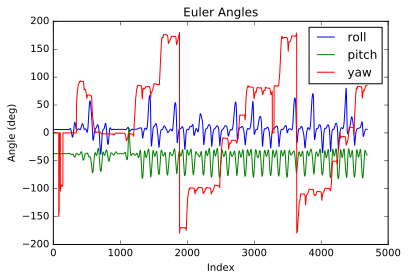

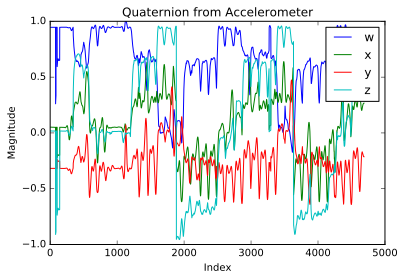

In [7]:
import matplotlib
import matplotlib.pyplot as plt

# First, some Jupyter plotting config
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

plt.plot( euler_meas*180.0/np.pi )  
plt.title('Euler Angles')
plt.xlabel('Index')
plt.ylabel('Angle (deg)')
plt.legend(['roll', 'pitch', 'yaw'])
plt.show()

plt.plot( quat_meas )  
plt.title('Quaternion from Accelerometer')
plt.xlabel('Index')
plt.ylabel('Magnitude')
plt.legend(['w','x','y','z'])
plt.show()

Looks good. Now all that is left is to loop over our sensor data and make calls to the EKF functions we defined earlier, which we'll do now.

In [46]:
# Some variables we'll need
KSTOP = 3000
state = state_init
P = P_init
time = 0
k = 0
t_last = tstamps[k]

# track our estimates, so we can plot them
quat_estimates = np.array([]).reshape(0,4)
pos_estimates = np.array([]).reshape(0,3)

for k in range(1,KSTOP):
    
    # gyro vector
    gyro_body = gyr_xyz[k,:]
    
    # lin-acc vector
    acc_body = lin_xyz[k,:]
    
    # quaternion vector
    qw, qx, qy, qz = quat_meas[k,:]
    
    # get measurement vector
    z = np.matrix([
            [qw],
            [qx],
            [qy],
            [qz],
        ])
        
    # time change
    dt = tstamps[k] - t_last
    t_last = tstamps[k]
    
    # forward propagation of state using rate gyros
    fcn_state_bound = lambda s: fcn_state(s, dt, gyro_body, acc_body)
    
    # kalman filter update
    state, P = ekfUpdate(fcn_state_bound, state, P, fcn_meas, z, dt*Q, R)

    quat_estimates = np.vstack([quat_estimates, [state.item(6), state.item(7), state.item(8), state.item(9)]])
    pos_estimates = np.vstack([pos_estimates, [state.item(0), state.item(1), state.item(2)]])
    
print('Measurement time elapsed:', np.round(t_last - tstamps[0],1), 'sec.')

('Measurement time elapsed:', 30.5, 'sec.')


And we're done! Let's plot the x and y coordinates from above so that we can see how closely we matched up with the earlier plot showing the motion capture ground truth.

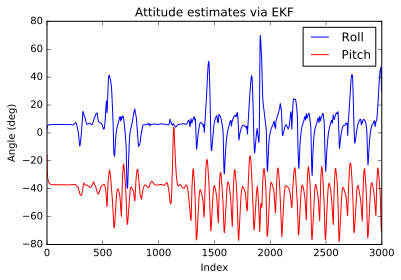

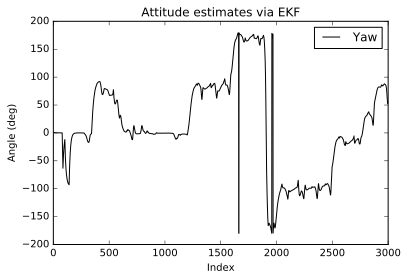

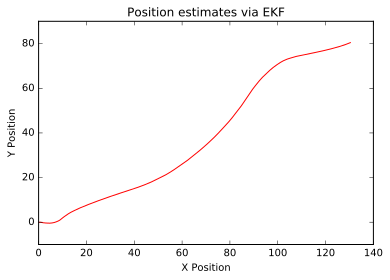

In [47]:
# convert quaternions to Euler for visualizing
q = quat_estimates
roll = np.arctan2( 2*(q[:,2]*q[:,3] + q[:,0]*q[:,1]), 1 - 2*(q[:,1]**2 + q[:,2]**2) )
pitch = -np.arcsin( 2*(q[:,1]*q[:,3] - q[:,0]*q[:,2]) )
yaw = np.arctan2( 2*(q[:,1]*q[:,2] + q[:,0]*q[:,3]), 1 - 2*(q[:,2]**2 + q[:,3]**2) )

# Plot pitch and roll
plt.plot(roll*180/np.pi, 'b-', markersize=3) 
plt.plot(pitch*180/np.pi, 'r-', markersize=3) 
plt.title('Attitude estimates via EKF')
plt.xlabel('Index')
plt.ylabel('Angle (deg)')
plt.legend(['Roll', 'Pitch'])
plt.show()

# Plot yaw
plt.plot(yaw*180/np.pi, 'k-', markersize=3) 
plt.title('Attitude estimates via EKF')
plt.xlabel('Index')
plt.ylabel('Angle (deg)')
plt.legend(['Yaw'])
plt.show()

# Plot position
plt.plot(pos_estimates[:,0], pos_estimates[:,1], 'r-')
plt.title('Position estimates via EKF')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()

Wonderful, right? Okay, what went wrong? The issue is that we don't really have any feedback--there's nothing to prevent the integration of acceleration into velocity terms and the integration of velocity into position.  That is, things will always just drift away without any feedback.

So we have a number of options: 1) if we have periodic GPS signals, we can add position feedback every once in a while, 2) if we have range measurements to anchor nodes we can use range feedback periodically, or 3) one common technique with foot-mounted sensors is something called ZUPT--a zero-velocity update technique where you detect footsteps and then force your state velocities to be equal to zero during those footsteps. This keeps things from diverging too drastically. 

Let's give that last one a shot here. First, let's try to design some metric for detecting footsteps.

In [58]:
def fcn_meas_pos(state):
    px = state.item(0)
    py = state.item(1)
    pz = state.item(2)
    qw  = state.item(6)
    qx  = state.item(7)
    qy  = state.item(8)
    qz  = state.item(9)
    
    # creating our predicted measurement matrix
    z = np.matrix([
            # High accuracy position estimates
            [px],
            [py],
            [pz],
            [qw],
            [qx],
            [qy],
            [qz],
        ])
    
    return z

Rpos = np.diag([0.01, 0.01, 0.01, cov_meas_ang, cov_meas_ang, cov_meas_ang, cov_meas_ang])

In [62]:
# Some variables we'll need
KSTOP = 3000
state = state_init
P = P_init
time = 0
k = 0
t_last = tstamps[k]

# track our estimates, so we can plot them
quat_estimates = np.array([]).reshape(0,4)
pos_estimates = np.array([]).reshape(0,3)
pos_truepoints = np.array([]).reshape(0,3)
vel_estimates = np.array([]).reshape(0,3)
PROB_POS = 0.01

for k in range(1,KSTOP):
    
    # do we get a position measurement?
    if np.random.rand() < PROB_POS:
        # quaternion vector
        qw, qx, qy, qz = quat_meas[k,:]
        
        # get true position
        xyz = tru_xyz[k,:]
        pos_truepoints = np.vstack([pos_truepoints, [xyz.item(0), xyz.item(1), xyz.item(2)]])
        
        z = np.matrix([
                [xyz.item(0)],
                [xyz.item(1)],
                [xyz.item(2)],
                [qw],
                [qx],
                [qy],
                [qz],
            ])
        
        # forward propagation of state using rate gyros
        fcn_state_bound = lambda s: fcn_state(s, dt, gyro_body, acc_body)

        # kalman filter update
        state, P = ekfUpdate(fcn_state_bound, state, P, fcn_meas_pos, z, dt*Q, Rpos)
        
    else:
        # gyro vector
        gyro_body = gyr_xyz[k,:]

        # lin-acc vector
        acc_body = lin_xyz[k,:]

        # quaternion vector
        qw, qx, qy, qz = quat_meas[k,:]

        # get measurement vector
        z = np.matrix([
                [qw],
                [qx],
                [qy],
                [qz],
            ])

        # time change
        dt = tstamps[k] - t_last
        t_last = tstamps[k]

        # forward propagation of state using rate gyros
        fcn_state_bound = lambda s: fcn_state(s, dt, gyro_body, acc_body)

        # kalman filter update
        state, P = ekfUpdate(fcn_state_bound, state, P, fcn_meas, z, dt*Q, R)

    pos_estimates = np.vstack([pos_estimates, [state.item(0), state.item(1), state.item(2)]])
    vel_estimates = np.vstack([vel_estimates, [state.item(3), state.item(4), state.item(5)]])
    quat_estimates = np.vstack([quat_estimates, [state.item(6), state.item(7), state.item(8), state.item(9)]])
    
print('Measurement time elapsed:', np.round(t_last - tstamps[0],1), 'sec.')

('Measurement time elapsed:', 30.5, 'sec.')


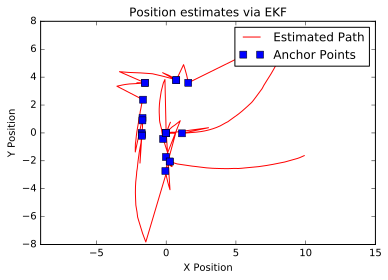

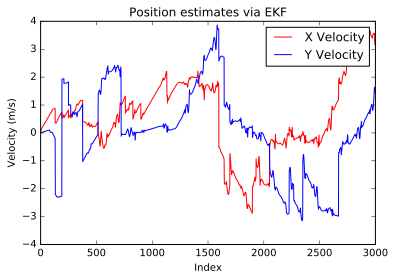

In [63]:
# Plot position
plt.plot(pos_estimates[:,0], pos_estimates[:,1], 'r-')
plt.plot(pos_truepoints[:,0], pos_truepoints[:,1], 'bs', markersize=7)
plt.title('Position estimates via EKF')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend(['Estimated Path', 'Anchor Points'])
plt.axis('equal')
plt.show()

plt.plot(vel_estimates[:,0], 'r-')
plt.plot(vel_estimates[:,1], 'b-')
plt.title('Position estimates via EKF')
plt.xlabel('Index')
plt.ylabel('Velocity (m/s)')
plt.legend(['X Velocity', 'Y Velocity'])
plt.show()

Much better! That's it for now!